## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [122]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot
from nengo.processes import Piecewise

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [123]:
map_a = np.array([[1, 2, 1], [1, 3, 5], [7, 1, 1]])

map_b = np.array([[1, 2, 1, 6], [1, 3, 5, 3], [7, 1, 4, 1]])

map_c = np.array(
    [
        [1, 3, 7, 2, 1],
        [3, 1, 5, 3, 1],
        [3, 2, 6, 1, 2],
        [3, 1, 5, 6, 1],
        [2, 2, 1, 1, 2],
    ]
)

map = map_a



(x, y) = np.shape(map)

print(x, y)

3 3


### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

top left corner
0
1
3
4
top right corner
2
1
5
4
bottom left corner
6
3
7
4
bottom right corner
8
5
7
4
top edge
1
0
2
4
3
5
next
bottom edge
7
6
8
4
3
5
next
left edge
3
0
1
4
6
7
next
right edge
5
2
1
4
8
7
next
middle
4
3
5
1
0
2
7
6
8
next


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

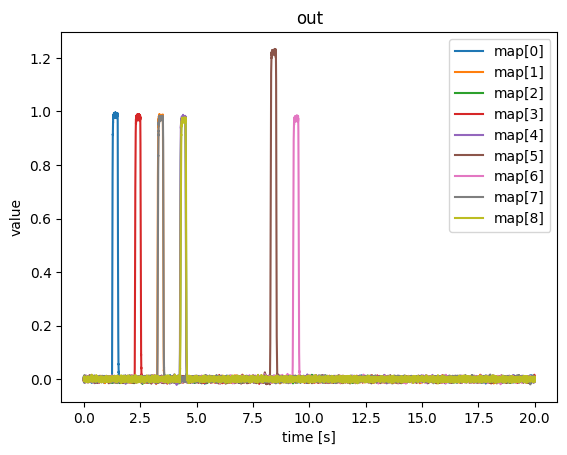

In [124]:
model = nengo.Network(label="Lab2")


with model:

    # start location of matrix
    start = 0
    # stop location of matrix
    stop = 8

    flattend_map = map.flatten()

    spikewave = nengo.Node(Piecewise({0: 0, 0.25: 1, 0.5: 0}))
    Ensemble = []
    for i in range(0, x * y):
        Ensemble.append(nengo.Ensemble(n_neurons=1000, dimensions=1, radius=1))

    class Delay:
        def __init__(self, dimensions, startspiking, stopspiking, time_delay=50):
            self.history = np.zeros((time_delay, dimensions))
            self.startspiking = False
            self.stopspiking = False

        def step(self, t, z):
            self.history = np.roll(self.history, -1)
            self.history[-1] = z

            if self.history[0] > 0.8 and self.startspiking == False:
                self.startspiking = True

            if self.startspiking == True and self.history[0] < 0.25:
                self.stopspiking = True

            if self.stopspiking == True:
                return 0
            else:
                return self.history[0]

    delaynode = []
    # delay = [None] * (x*y)
    for i in range(0, x * y):
        # print(i)
        dt = 0.001
        time_delay = (flattend_map[i]) / dt
        delay = Delay(
            dimensions=1,
            startspiking=False,
            stopspiking=False,
            time_delay=int(time_delay),
        )
        delaynode.append(nengo.Node(delay.step, size_in=1, size_out=1))
        nengo.Connection(delaynode[i], Ensemble[i])

    # corner connection
    for i in range(0, 1):
        print("top left corner")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[1])
        nengo.Connection(Ensemble[i], delaynode[y])
        nengo.Connection(Ensemble[i], delaynode[y + 1])
        print(i)
        print(1)
        print(y)
        print(y + 1)
    for i in range(y - 1, y):
        print("top right corner")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[y - 2])
        nengo.Connection(Ensemble[i], delaynode[(2 * y) - 1])
        nengo.Connection(Ensemble[i], delaynode[(2 * y) - 2])
        print(i)
        print(y - 2)
        print((2 * y) - 1)
        print((2 * y) - 2)

    for i in range((x * y) - y, (x * y) - y + 1):
        print("bottom left corner")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[(x * y) - (2 * y)])
        nengo.Connection(Ensemble[i], delaynode[i + 1])
        nengo.Connection(Ensemble[i], delaynode[(x * y) - (2 * y) + 1])
        print(i)
        print((x * y) - (2 * y))
        print(i + 1)
        print((x * y) - (2 * y) + 1)

    for i in range((x * y) - 1, (x * y)):
        print("bottom right corner")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[(x * y) - y - 1])
        nengo.Connection(Ensemble[i], delaynode[(x * y) - 2])
        nengo.Connection(Ensemble[i], delaynode[(x * y) - y - 2])
        print(i)
        print((x * y) - y - 1)
        print((x * y) - 2)
        print((x * y) - y - 2)

    for i in range(1, y - 1):
        print("top edge")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[i - 1])
        nengo.Connection(Ensemble[i], delaynode[i + 1])
        nengo.Connection(Ensemble[i], delaynode[i + y])
        nengo.Connection(Ensemble[i], delaynode[i + y - 1])
        nengo.Connection(Ensemble[i], delaynode[i + y + 1])
        print(i)
        print(i - 1)
        print(i + 1)
        print(i + y)
        print(i + y - 1)
        print(i + y + 1)
        print("next")

    for i in range((x * y) - y + 1, (x * y) - 1):
        print("bottom edge")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[i - 1])
        nengo.Connection(Ensemble[i], delaynode[i + 1])
        nengo.Connection(Ensemble[i], delaynode[i - y])
        nengo.Connection(Ensemble[i], delaynode[i - y - 1])
        nengo.Connection(Ensemble[i], delaynode[i - y + 1])
        print(i)
        print(i - 1)
        print(i + 1)
        print(i - y)
        print(i - y - 1)
        print(i - y + 1)
        print("next")

    for i in range(y, (x * y) - y, y):
        print("left edge")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[i - y])
        nengo.Connection(Ensemble[i], delaynode[i - y + 1])
        nengo.Connection(Ensemble[i], delaynode[i + 1])
        nengo.Connection(Ensemble[i], delaynode[i + y])
        nengo.Connection(Ensemble[i], delaynode[i + y + 1])
        print(i)
        print(i - y)
        print(i - y + 1)
        print(i + 1)
        print(i + y)
        print(i + y + 1)
        print("next")

    for i in range((2 * y) - 1, (x * y) - 1, y):
        print("right edge")
        # print(i)
        if start == i:
            nengo.Connection(spikewave, delaynode[i])
        nengo.Connection(Ensemble[i], delaynode[i - y])
        nengo.Connection(Ensemble[i], delaynode[i - y - 1])
        nengo.Connection(Ensemble[i], delaynode[i - 1])
        nengo.Connection(Ensemble[i], delaynode[i + y])
        nengo.Connection(Ensemble[i], delaynode[i + y - 1])
        print(i)
        print(i - y)
        print(i - y - 1)
        print(i - 1)
        print(i + y)
        print(i + y - 1)
        print("next")

    for i in range(y, (x * y) - y):
        if i % y != 0 and i % y != y - 1:
            print("middle")
            # print(i)
            if start == i:
                nengo.Connection(spikewave, delaynode[i])
            nengo.Connection(Ensemble[i], delaynode[i - 1])
            nengo.Connection(Ensemble[i], delaynode[i + 1])
            nengo.Connection(Ensemble[i], delaynode[i - y])
            nengo.Connection(Ensemble[i], delaynode[i - y - 1])
            nengo.Connection(Ensemble[i], delaynode[i - y + 1])
            nengo.Connection(Ensemble[i], delaynode[i + y])
            nengo.Connection(Ensemble[i], delaynode[i + y - 1])
            nengo.Connection(Ensemble[i], delaynode[i + y + 1])
            print(i)
            print(i - 1)
            print(i + 1)
            print(i - y)
            print(i - y - 1)
            print(i - y + 1)
            print(i + y)
            print(i + y - 1)
            print(i + y + 1)
            print("next")

    map_probes = [None] * (x * y)
    delay_probe = [None] * (x * y)

    for i in range(0, x * y):
        map_probes[i] = nengo.Probe(Ensemble[i], synapse=0.01)
        delay_probe[i] = nengo.Probe(delaynode[i], synapse=0.01)

    with nengo.Simulator(model) as sim:
        sim.run(20)

    plt.figure()
    for i in range(0, x * y):
        plt.plot(sim.trange(), sim.data[map_probes[i]], label="map" + str([i]))
        # plt.plot(sim.trange(), sim.data[delay_probe[i]], label="delay"+ str([i]))
    plt.legend(loc=1)
    plt.xlabel("time [s]")
    plt.ylabel("value")
    plt.title("out")
    plt.show()

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

In [125]:
aer = []
spikes_locs = []
first_spike = []
for i in range(0, x * y):
    # print(i)
    aer.append(sim.data[map_probes[i]][:, 0] > 0.25)
    spikes_locs.append(np.where(aer[i] == True))
    first_spike.append(np.min(spikes_locs[i]))


path = [1]
stop = 8
start = 0
bestpath = []
g = 0
while path[g] != start:
    for i in range(0, 1):
        if stop == i:
            path.append(i)
            minlist = [first_spike[1], first_spike[y], first_spike[y + 1]]
            if first_spike[1] == np.min(minlist):
                stop = 1
            elif first_spike[y] == np.min(minlist):
                stop = y
            elif first_spike[y + 1] == np.min(minlist):
                stop = y + 1

    for i in range(y - 1, y):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[y - 2],
                first_spike[(2 * y) - 1],
                first_spike[(2 * y) - 2],
            ]
            if first_spike[y - 2] == np.min(minlist):
                stop = y - 2
            elif first_spike[(2 * y) - 1] == np.min(minlist):
                stop = (2 * y) - 1
            elif first_spike[(2 * y) - 2] == np.min(minlist):
                stop = (2 * y) - 2

    for i in range((x * y) - y, (x * y) - y + 1):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[(x * y) - y - 1],
                first_spike[(x * y) - 2],
                first_spike[(x * y) - 2 * y - 1],
            ]
            if first_spike[(x * y) - y - 1] == np.min(minlist):
                stop = (x * y) - y - 1
            elif first_spike[(x * y) - 2] == np.min(minlist):
                stop = (x * y) - 2
            elif first_spike[(x * y) - 2 * y - 1] == np.min(minlist):
                stop = (x * y) - 2 * y - 1

    for i in range((x * y) - 1, (x * y)):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[(x * y) - y - 2],
                first_spike[(x * y) - 2],
                first_spike[(x * y) - y - 2],
            ]
            if first_spike[(x * y) - y - 2] == np.min(minlist):
                stop = (x * y) - y - 2
                # print((x*y)-y-2)
            elif first_spike[(x * y) - 2] == np.min(minlist):
                stop = (x * y) - 2
                # print((x*y)-2)
            elif first_spike[(x * y) - y - 2] == np.min(minlist):
                stop = (x * y) - y - 2
                # print((x*y)-y-2)

    for i in range(1, y - 1):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[i - 1],
                first_spike[i + 1],
                first_spike[i + y],
                first_spike[i + y - 1],
                first_spike[i + y + 1],
            ]
            if first_spike[i - 1] == np.min(minlist):
                stop = i - 1
            elif first_spike[i + 1] == np.min(minlist):
                stop = i + 1
            elif first_spike[i + y] == np.min(minlist):
                stop = i + y
            elif first_spike[i + y - 1] == np.min(minlist):
                stop = i + y - 1
            elif first_spike[i + y + 1] == np.min(minlist):
                stop = i + y + 1

    for i in range((x * y) - y + 1, (x * y) - 1):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[i - 1],
                first_spike[i + 1],
                first_spike[i - y],
                first_spike[i - y - 1],
                first_spike[i - y + 1],
            ]
            if first_spike[i - 1] == np.min(minlist):
                stop = i - 1
            elif first_spike[i + 1] == np.min(minlist):
                stop = i + 1
            elif first_spike[i - y] == np.min(minlist):
                stop = i - y
            elif first_spike[i - y - 1] == np.min(minlist):
                stop = i - y - 1
            elif first_spike[i - y + 1] == np.min(minlist):
                stop = i - y + 1

    for i in range(y, (x * y) - y, y):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[i - y],
                first_spike[i - y + 1],
                first_spike[i + 1],
                first_spike[i + y],
                first_spike[i + y + 1],
            ]
            if first_spike[i - y] == np.min(minlist):
                stop = i - y
            elif first_spike[i - y + 1] == np.min(minlist):
                stop = i - y + 1
            elif first_spike[i + 1] == np.min(minlist):
                stop = i + 1
            elif first_spike[i + y] == np.min(minlist):
                stop = i + y
            elif first_spike[i + y + 1] == np.min(minlist):
                stop = i + y + 1

    for i in range((2 * y) - 1, (x * y) - y, y):
        if stop == i:
            path.append(i)
            minlist = [
                first_spike[i - y],
                first_spike[i - y - 1],
                first_spike[i - 1],
                first_spike[i + y],
                first_spike[i + y - 1],
            ]
            if first_spike[i - y] == np.min(minlist):
                stop = i - y
            elif first_spike[i - y - 1] == np.min(minlist):
                stop = i - y - 1
            elif first_spike[i - 1] == np.min(minlist):
                stop = i - 1
            elif first_spike[i + y] == np.min(minlist):
                stop = i + y
            elif first_spike[i + y - 1] == np.min(minlist):
                stop = i + y - 1

    for i in range(y, (x * y) - y):
        if i % y != 0 and i % y != y - 1:
            if stop == i:
                path.append(i)
                minlist = [
                    first_spike[i - 1],
                    first_spike[i + 1],
                    first_spike[i - y],
                    first_spike[i - y - 1],
                    first_spike[i - y + 1],
                    first_spike[i + y],
                    first_spike[i + y - 1],
                    first_spike[i + y + 1],
                ]
                if first_spike[i - 1] == np.min(minlist):
                    stop = i - 1
                elif first_spike[i + 1] == np.min(minlist):
                    stop = i + 1
                elif first_spike[i - y] == np.min(minlist):
                    stop = i - y
                elif first_spike[i - y - 1] == np.min(minlist):
                    stop = i - y - 1
                elif first_spike[i - y + 1] == np.min(minlist):
                    stop = i - y + 1
                elif first_spike[i + y] == np.min(minlist):
                    stop = i + y
                elif first_spike[i + y - 1] == np.min(minlist):
                    stop = i + y - 1
                elif first_spike[i + y + 1] == np.min(minlist):
                    stop = i + y + 1
    # print(path[g])
    g = g + 1
    # print(path[g])
    bestpath.append(path[g])


print(bestpath)

[8, 7, 3, 0]


### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

In [126]:
finalpath = bestpath

# print(finalpath)

loc = []

for i in range(1, len(finalpath) + 1):
    loc.append(finalpath[len(finalpath) - i])

print(
    "flattened path locations start =" + str(loc[0]) + " end =" + str(loc[len(loc) - 1])
)
print(loc)

flattened path locations start =0 end =8
[0, 3, 7, 8]
